<a href="https://colab.research.google.com/github/JordanFoss/STAT3007_Project/blob/main/CNN_LSTM_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading all the needed things


In [3]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 4337, done.
remote: Counting objects: 100% (615/615), done.
remote: Compressing objects: 100% (384/384), done.
remote: Total 4337 (delta 241), reused 602 (delta 228), pack-reused 3722
Receiving objects: 100% (4337/4337), 977.85 MiB | 25.10 MiB/s, done.
Resolving deltas: 100% (826/826), done.
Checking out files: 100% (2942/2942), done.
/content/STAT3007_Project


In [4]:
!pip install colorednoise as cn

  Created wheel for colorednoise: filename=colorednoise-1.1.1-cp37-none-any.whl size=3983 sha256=cdb114c783c22d6f3ebdb73acb07fdbc8b92921882a92808fc2a68c0fa4313f5
  Stored in directory: /root/.cache/pip/wheels/84/be/f3/3e7e1c80ebab3f6f0dbd3e34e787b902d2280d66706485fef4
Successfully built colorednoise


In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import scipy
import numpy as np
import librosa
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
import pandas as pd
import glob
import os
from librosa import display
from torchsummary import summary
import sklearn

from IPython.display import Audio

# load our own python files
from pre_process import *
from data_loading import *
from Models import *
from Model_Functions import *

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Clean Data (from github repo)

In [7]:
# loads all clean samples
X,y = load_samples(os.getcwd())
X = torch.tensor(X)
X = X.reshape(X.shape[0],1,X.shape[1],X.shape[2])
y = torch.tensor(y)

# train/test split and make into datasets
data_sets = load_sets(X,y,train_ratio=[0.8], seed = [10])
data_train, data_test = data_sets[0]

## Load Noisy data (from google drive)

In [8]:
#Import all the splited noisy data
noisy_data_train = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/noisy_train_snr40.npy')
noisy_data_test = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/noisy_test_snr40.npy')
noisy_targets_train = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/target_train_snr40.npy')
noisy_targets_test = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/target_test_snr40.npy')

# reformat
noisy_data_train = noisy_data_train.reshape(noisy_data_train.shape[0],1,noisy_data_train.shape[1],noisy_data_train.shape[2])
noisy_data_test = noisy_data_test.reshape(noisy_data_test.shape[0],1,noisy_data_test.shape[1],noisy_data_test.shape[2])
noisy_data_train = torch.tensor(noisy_data_train)
noisy_data_test = torch.tensor(noisy_data_test)

noisy_targets_train = torch.tensor(noisy_targets_train)
noisy_targets_test = torch.tensor(noisy_targets_test)

# make into datasets
noisy_train = DatasetWrapper(noisy_data_train,noisy_targets_train)
noisy_test = DatasetWrapper(noisy_data_test,noisy_targets_test)

# Train function

In [9]:
def train_model(data_train, 
                data_test, 
                net, loss, 
                nepoch , 
                lr = 0.01, 
                batch_size = -1, 
                momentum = 0,
                use_cuda = False, 
                print_output = True, 
                optimiser = 'SGD'):

  # setting up arrays for recording
  test_acc = []
  avg_acc = []
  test_loss = []
  avg_loss = []

  # appropriate data type for CPU or GPU
  device = None
  if use_cuda and torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda")
    net = net.to(device)
  else:
    dtype = torch.FloatTensor

  # choice of optimiser
  if optimiser == 'SGD':
    optimizer = optim.SGD(net.parameters(), lr = lr, momentum = momentum)
  else:
    optimizer = optim.Adam(net.parameters(), lr = lr, momentum = momentum)

  
  data_train = data_train.change_type(dtype)
  data_test = data_test.change_type(dtype)


  X_test,y_test = data_test.get_data()

  # for entropy loss
  y_test = y_test.type(torch.LongTensor)
  if device != None:
    y_test = y_test.type(torch.cuda.LongTensor)

  data_loader = DataLoader(data_train, batch_size = batch_size, shuffle = True)

  for epoch in range(nepoch):
    batch_acc = []
    batch_loss = []
    for X_batch, y_batch in data_loader:
      
      # change data type
      y_batch = y_batch.type(torch.LongTensor)
      if use_cuda and device != None:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_batch = y_batch.type(torch.cuda.LongTensor)

      optimizer.zero_grad()

      pred = net(X_batch, use_cuda = use_cuda)
      Rn = loss(pred, y_batch)
      accur = accuracy(pred,y_batch)

      batch_acc.append(accur)
      batch_loss.append(Rn.to(torch.device('cpu')).detach().numpy())

      Rn.backward()
      optimizer.step()

    # average batch status
    avg_batch_loss = np.mean(batch_loss)
    avg_batch_acc = np.mean(batch_acc)

    avg_acc.append(avg_batch_acc)
    avg_loss.append(avg_batch_loss)

    # test results in current epoch
    pred = net(X_test, use_cuda = use_cuda)
    Rn = loss(pred, y_test)
    accur = accuracy(pred,y_test)
    test_acc.append(accur)
    test_loss.append(Rn.to(torch.device('cpu')).detach().numpy())


    if print_output:
      print('epoch:', epoch)
      print('loss:',Rn.item())
      print('------------')
    

  print('final loss:', Rn.item())

  return net, avg_loss, avg_acc, test_loss, test_acc

# Hyperparameter tuning
__finalised__:
* random seed = 69
* Optimiser: SGD
* lr: 0.01
* epoch number: 40 
* momentum: 0.2

final loss: 1.5960513353347778
final loss: 1.5817543268203735
final loss: 1.5622577667236328
final loss: 1.5353151559829712
final loss: 1.4976733922958374
final loss: 1.4537428617477417
final loss: 1.4130727052688599
final loss: 1.3744512796401978
final loss: 1.3470083475112915
final loss: 1.316717267036438
final loss: 1.580527424812317
final loss: 1.5327855348587036
final loss: 1.444177269935608
final loss: 1.3348608016967773
final loss: 1.239195704460144
final loss: 1.1649430990219116
final loss: 1.113086462020874
final loss: 1.0764449834823608
final loss: 1.0419412851333618
final loss: 1.035400390625
final loss: 1.565245509147644
final loss: 1.4566298723220825
final loss: 1.304161548614502
final loss: 1.2026851177215576
final loss: 1.1436940431594849
final loss: 1.097208857536316
final loss: 1.0586069822311401
final loss: 1.047970175743103
final loss: 0.9903509616851807
final loss: 0.9696678519248962
final loss: 1.535894513130188
final loss: 1.3339234590530396
final loss: 1.15795934

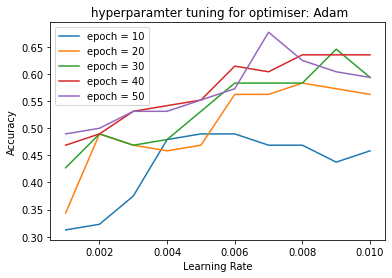

In [12]:
# hyperparameter tuning for optimiser, lr and nepoch
epoch = [i for i in range(10, 51,10)]
fig = plt.figure()
loss = nn.CrossEntropyLoss()
optimiser = 'Adam'
plt.title(' hyperparamter tuning for optimiser: ' + optimiser)
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')

for nepoch in epoch:

  lrs = [i * 0.001 for i in range(1, 11)]
  acc = []
  for lr in lrs:
    torch.manual_seed(69)
    CNN = ConvNet()
    conv_LSTM = LRCN(CNN)
    trained_net,avg_loss, avg_acc, test_loss, test_acc = train_model(data_train, data_test, conv_LSTM, loss, nepoch=nepoch , batch_size = 10,lr = lr, use_cuda = True, print_output = False, optimiser = 'SGD')
    X_test, y_test = data_test.get_data()
    trained_net = trained_net.to(torch.device('cpu'))
    pred = trained_net(X_test)
    accur = accuracy(pred,y_test)
    acc.append(accur)
  
  plt.plot(lrs,acc, label = 'epoch = ' + str(nepoch))

plt.legend()

final loss: 1.5960513353347778
final loss: 1.5817543268203735
final loss: 1.5622624158859253
final loss: 1.5353151559829712
final loss: 1.497676968574524
final loss: 1.4537080526351929
final loss: 1.413101077079773
final loss: 1.3744274377822876
final loss: 1.3448128700256348
final loss: 1.3178635835647583
final loss: 1.5805259943008423
final loss: 1.5327798128128052
final loss: 1.444167971611023
final loss: 1.334921956062317
final loss: 1.2396196126937866
final loss: 1.168324589729309
final loss: 1.1122146844863892
final loss: 1.0926507711410522
final loss: 1.0398176908493042
final loss: 1.0221511125564575
final loss: 1.5652451515197754
final loss: 1.456631064414978
final loss: 1.30422043800354
final loss: 1.2029781341552734
final loss: 1.1414180994033813
final loss: 1.079119324684143
final loss: 1.0301718711853027
final loss: 1.0255824327468872
final loss: 1.007027268409729
final loss: 1.011792778968811
final loss: 1.5358967781066895
final loss: 1.3339405059814453
final loss: 1.15839

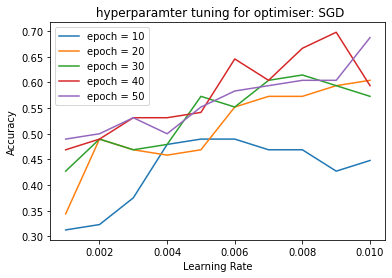

In [14]:
# hyperparameter tuning for optimiser, lr and nepoch
epoch = [i for i in range(10, 51,10)]
fig = plt.figure()
loss = nn.CrossEntropyLoss()
optimiser = 'SGD'
plt.title(' hyperparamter tuning for optimiser: ' + optimiser)
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')

for nepoch in epoch:

  lrs = [i * 0.001 for i in range(1, 11)]
  acc = []
  for lr in lrs:
    torch.manual_seed(69)
    CNN = ConvNet()
    conv_LSTM = LRCN(CNN)
    trained_net,avg_loss, avg_acc, test_loss, test_acc = train_model(data_train, data_test, conv_LSTM, loss, nepoch=nepoch , batch_size = 10,lr = lr, use_cuda = True, print_output = False, optimiser = 'SGD')
    X_test, y_test = data_test.get_data()
    trained_net = trained_net.to(torch.device('cpu'))
    pred = trained_net(X_test)
    accur = accuracy(pred,y_test)
    acc.append(accur)
  
  plt.plot(lrs,acc, label = 'epoch = ' + str(nepoch))

plt.legend()

final loss: 0.7707245945930481
final loss: 0.7741596698760986
final loss: 0.7580082416534424
final loss: 0.8585305213928223
final loss: 1.0053373575210571
final loss: 0.8399456143379211
final loss: 0.9833918213844299
final loss: 0.9600781798362732


No handles with labels found to put in legend.


final loss: 1.490085244178772


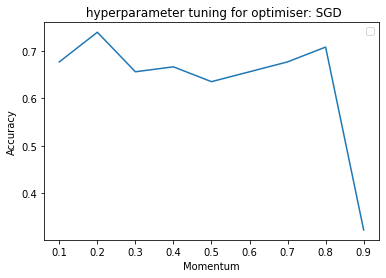

In [ ]:
# momentum training
momentums = [i*0.1 for i in range(1,10)]
acc = []
fig = plt.figure()
loss = nn.CrossEntropyLoss()
optimiser = 'SGD'
plt.title(' hyperparameter tuning for optimiser: ' + optimiser)
plt.ylabel('Accuracy')
plt.xlabel('Momentum')
nepoch = 40
lr = 0.01

for momentum in momentums:

  torch.manual_seed(69)
  CNN = ConvNet()
  conv_LSTM = LRCN(CNN)
  trained_net,avg_loss, avg_acc, test_loss, test_acc = train_model(data_train, data_test, conv_LSTM, loss, nepoch=nepoch, momentum = momentum ,batch_size = 10,lr = lr, use_cuda = True, print_output = False, optimiser = 'SGD')
  X_test, y_test = data_test.get_data()
  trained_net = trained_net.to(torch.device('cpu'))
  pred = trained_net(X_test)
  accur = accuracy(pred,y_test)
  acc.append(accur)
  
plt.plot(momentums,acc)